In [14]:
%matplotlib inline
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# 装载数据库

In [15]:
db_filename='dinofunworld.db'
conn = sqlite3.connect(db_filename)
cursor = conn.cursor()

# 作业1
游乐园的管理员希望你帮助他们了解游客游览游乐园的不同路线以及他们参加的不同游乐项目。在此任务中，他们随机选择了 5 名游客，并希望你分析这些游客的登记序列。现在，他们希望你针对这 5 名游客构造一个距离矩阵。五名游客的编号为：165316、1835254、296394、404385 和 448990。

## 了解 sequences 表的schema

In [16]:
cursor.execute("PRAGMA table_info(sequences)")
pd.DataFrame(cursor.fetchall(),columns=['cid', 'name', 'type', 'notnull', 'defualt_value', 'pk'])

,cid,name,type,notnull,defualt_value,pk
0,0,index,INTEGER,0,None,0
1,1,visitorID,INTEGER,0,None,0
2,2,sequence,TEXT,0,None,0


## 探索 sequences

In [17]:
sql=("SELECT visitorID, sequence "
    "FROM sequences "
    "WHERE visitorID=165316 "
    "or visitorID=1835254")
data = cursor.execute(sql).fetchall()
data

[(165316,
  '0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-83-83-81-81-81-28-28-44-44-44-44-34-34-34-0-33-33-33-33-33-33-33-33-33-33-33-33-22-22-5-5-5-5-5-5-5-5-5-5-5-5-0-15-15-14-0-33-33-33-33-33-33-42-42-42-65-65-65-0-81-81-81-81-81-81-81-81-81-81-81-81-81-81-4-4-4-4-4-4-4-4-4-4-4-4-34-34-34-34-34-34-34-34-34-34-34-34-34-34-34-34-61-61-61-61-61-61-61-61-41-41-41-41-0-48-48-47-47-47-0-46-46-48-48-48-48-48-48-46-46-46-46-46-48-48-48-48-48-48-48-48-0-54-54-54-54-54-54-54-54-37-37-0-35-35-35-35-35-35-35-83-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-83-40-40-2-2-25-25-0-34-34-34-34-34-34-34-30-30-30-30-30-30-30-28-28-16-16-0-0-0-0-0-4

## 探索每个人访问序列如何对应

In [18]:
for person in data:
    print(len(person[1].split('-')))

576
576


## 探索序列如何和 checkin 记录对应

In [19]:
sql=("SELECT visitorID,attraction "
    "FROM checkin "
    "WHERE visitorID=165316 "
    "ORDER BY timestamp limit 0, 10")
data = cursor.execute(sql).fetchall()
pd.DataFrame(data,columns=['VisitorID', 'Attraction'])

,VisitorID,Attraction
0,165316,83
1,165316,81
2,165316,28
3,165316,44
4,165316,34
5,165316,33
6,165316,22
7,165316,5
8,165316,15
9,165316,14


## 探索结论
sequence字段是按5分钟时间间隔记录了游客访问景点的情况，不为0时为 attractionID

## 将 sequence 转化为访问特征向量，并用 Hamming distance 计算特征之间的距离

In [20]:
sql=("SELECT visitorID, sequence "
    "FROM sequences "
    "WHERE visitorID=165316 "
    "or visitorID=1835254 "
    "or visitorID=296394 "
    "or visitorID=404385 "
    "or visitorID=448990 ")
data = cursor.execute(sql).fetchall()

visitors = {}

for vr in data:
    seq = vr[1].split("-")
    visitors[vr[0]]=np.array([int(attraction) for attraction in seq])


下面是Hamming distance 计算函数

In [21]:
def hamming(x, y):
    return np.count_nonzero(x != y)/len(x)

开始计算各个访客之间的距离

In [22]:
dinstance_matrix = []
labels = [0]
seq_size = 0
for key in visitors:
    labels.append(key)
    features = visitors[key]
    seq_size = len(features)
    dinstance_matrix.append([hamming(features,visitors[k]) for k in visitors])


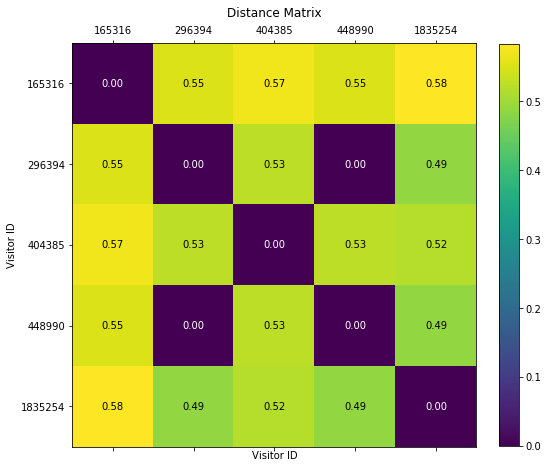

In [23]:
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

cax = plt.matshow(dinstance_matrix)

ax = plt.gca()
ax.set_title('Distance Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel('Visitor ID')
ax.set_ylabel('Visitor ID')
plt.colorbar(cax,fraction=0.045, pad=0.05)

for (i, j), z in np.ndenumerate(dinstance_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), \
            ha='center', va='center',\
            color="black" if z > 0 else "white")

plt.show()

# 作业2 
游乐园的管理员想要了解每个游乐项目的参加动态（请注意，并非所有景点都是游乐项目）。他们希望看到一张图(例如平行坐标图)上看到每个游乐项目的最小（非零）参入量、一整天的平均参入量以及每个游乐项目的最大参入量。

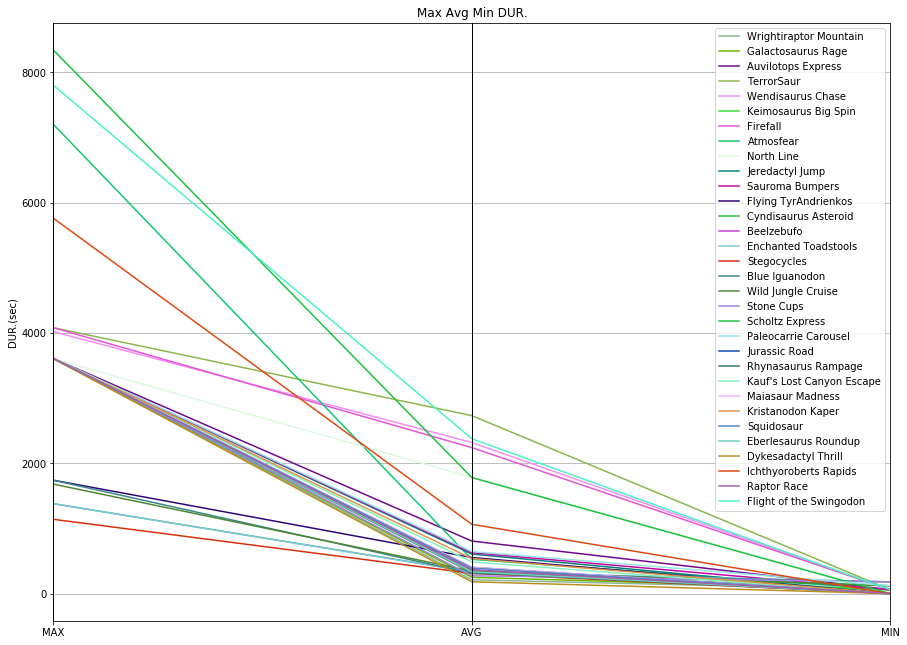

In [28]:
from pandas.plotting import parallel_coordinates
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 11.0)

sql = ("SELECT t2.name, "
        "MAX(cast(substr(t1.duration,1,1) as int)*3600+"
       "cast(substr(t1.duration,3,2) as int)*60+"
       "cast(substr(t1.duration,5,2) as int)) as dt_max, "
        "AVG(cast(substr(t1.duration,1,1) as int)*3600+"
       "cast(substr(t1.duration,3,2) as int)*60+"
       "cast(substr(t1.duration,5,2) as int)) as dt_avg, "
       "MIN(cast(substr(t1.duration,1,1) as int)*3600+"
       "cast(substr(t1.duration,3,2) as int)*60+"
       "cast(substr(t1.duration,5,2) as int)) as dt "
      "FROM checkin t1 inner join attraction t2 "
      "ON t1.attraction = t2.AttractionID "
      "WHERE cast(substr(t1.duration,1,1) as int)*3600+"
       "cast(substr(t1.duration,3,2) as int)*60+"
       "cast(substr(t1.duration,5,2) as int)> 0 "
       "AND category='Thrill Rides\r' "
      "OR category='Kiddie Rides\r' "
      "OR category='Rides for Everyone\r' "
      "GROUP BY t2.AttractionID ")
data = cursor.execute(sql).fetchall()

pdata = pd.DataFrame(data,columns=['attraction','MAX','AVG','MIN'])
ax = parallel_coordinates(pdata,"attraction")
ax.set_title('Max Avg Min DUR.')
ax.set_ylabel('DUR.(sec)')
plt.show()

# 作业3
除了 平行坐标图，管理员希望看到描述每个游乐项目的最小、平均和最大参入量的散点图矩阵

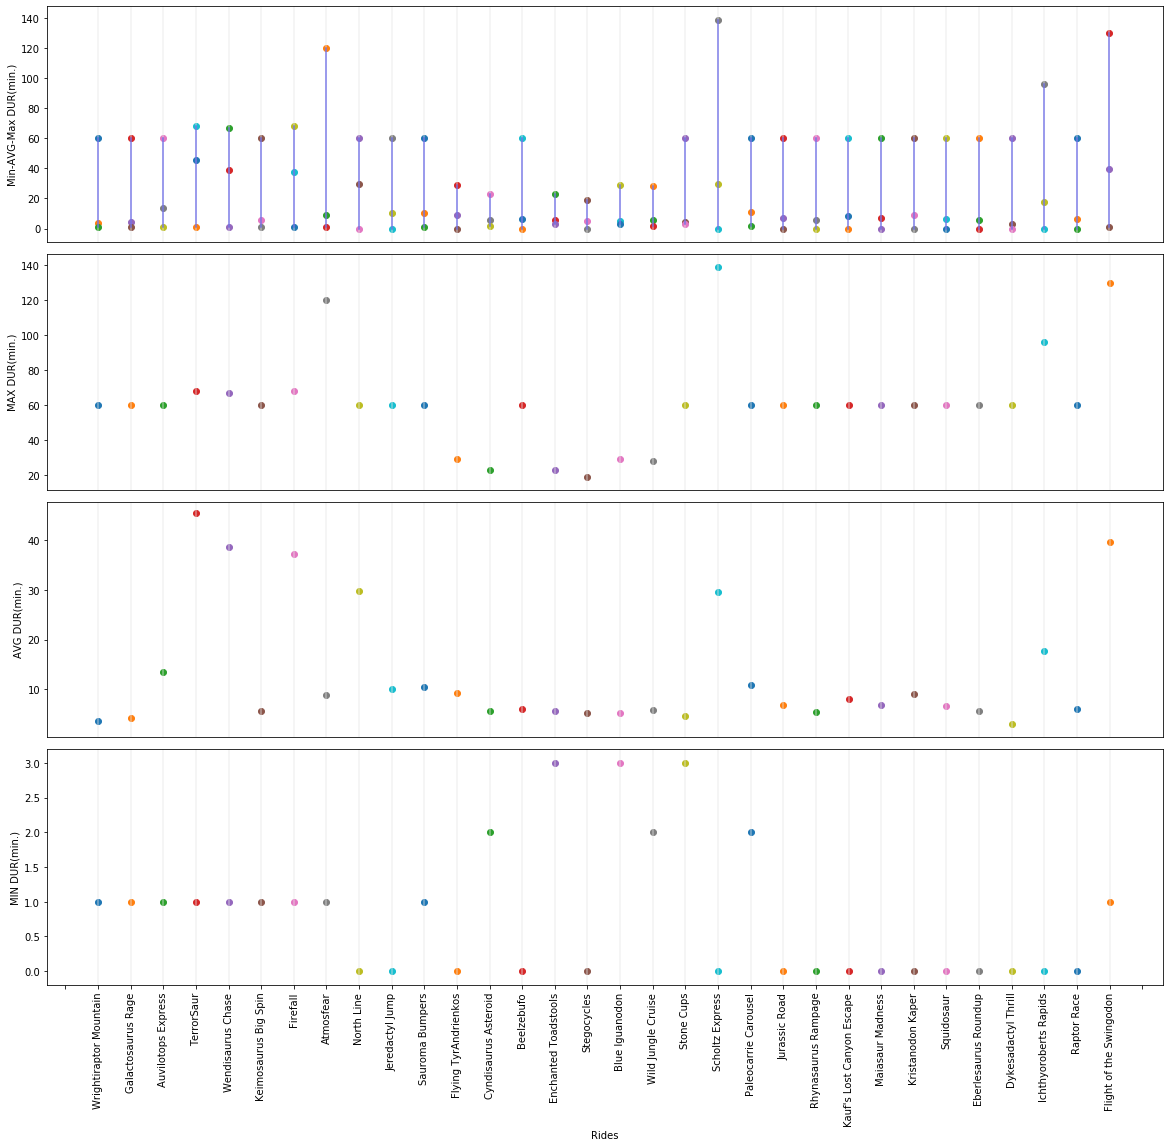

In [29]:
import matplotlib.ticker as ticker
import matplotlib.lines as lines
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 18.0)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1)
plt.subplots_adjust(wspace =0, hspace =0.05)

labels = ["",""]
for i, row in enumerate(data):
    ax0.add_line(lines.Line2D([i,i], [row[1]/60,row[3]/60],color=(0.0, 0.0, 0.9, 0.75)))
    ax0.scatter(i,row[1]/60)
    ax0.scatter(i,row[2]/60)
    ax0.scatter(i,row[3]/60)
    ax0.axvline(x=i,color=(0.9, 0.9, 0.9, 0.5))
    ax0.set_xticks([])
    ax0.set_ylabel('Min-AVG-Max DUR(min.)')
    
    
    ax1.scatter(i,row[1]/60)
    ax1.set_ylabel('MAX DUR(min.)')
    ax1.set_xticks([])
    ax1.axvline(x=i,color=(0.9, 0.9, 0.9, 0.5))
    ax2.scatter(i,row[2]/60)
    ax2.set_xticks([])
    ax2.set_ylabel('AVG DUR(min.)')
    ax2.axvline(x=i,color=(0.9, 0.9, 0.9, 0.5))
    ax3.scatter(i,row[3]/60)
    ax3.set_ylabel('MIN DUR(min.)')
    ax3.axvline(x=i,color=(0.9, 0.9, 0.9, 0.5))
    ax3.set_xlabel('Rides')
    labels.append(row[0])

ax3.xaxis.set_major_locator(ticker.MultipleLocator())

ax3.set_xticklabels(labels,rotation=90)
plt.savefig('./subplot.png')
plt.show()
    

## 结果讨论
说明：最顶端的图我尝试在同一个 scatter plot 图中将最大值，均值，最小值连线，应该能更直观的表达游客所用时间的分布情况。scatter plot matrix 还是不够直观，下面会用 box plot展现，方便用户直接观察到数据的分布情况。

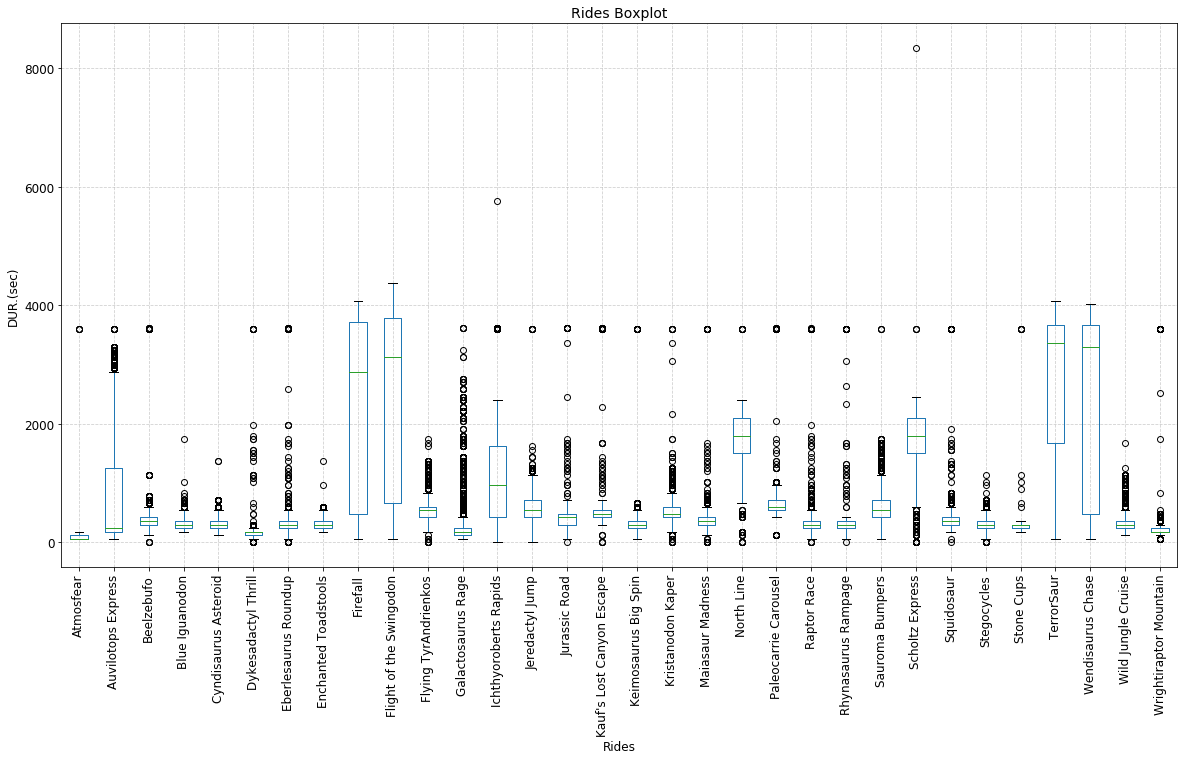

In [30]:
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

sql = ("SELECT t2.name, "
        "(cast(substr(t1.duration,1,1) as int)*3600+"
       "cast(substr(t1.duration,3,2) as int)*60+"
       "cast(substr(t1.duration,5,2) as int)) DUR "
      "FROM checkin t1 inner join attraction t2 "
      "ON t1.attraction = t2.AttractionID "
      "WHERE DUR> 0 "
       "AND t1.type='actual' "
       "AND category='Thrill Rides\r' "
      "OR category='Kiddie Rides\r' "
      "OR category='Rides for Everyone\r' ")
data = cursor.execute(sql).fetchall()

df = pd.DataFrame(data,columns=['attraction','DUR'])
grouped = df.groupby('attraction')

labels = [key for key,_ in grouped]

ax = grouped.boxplot(rot=90, fontsize=12, subplots=False)
##ax.set_xticks([])
ax.set_xticklabels(labels,rotation=90)
plt.title( "Rides Boxplot",fontsize=14 )
plt.grid(linestyle="--", alpha=0.6)
plt.ylabel("DUR.(sec)",fontsize=12)
plt.xlabel("Rides",fontsize=12)
plt.show()

## Boxplot 更方便对比各个设施的访问时间分布情况